In [1]:
import numpy as np
import mosek
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = expm(A*delta_t)
    Bk = (expm(A * delta_t) - Ix) @ np.linalg.inv(A) @ B

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn

In [3]:
# Collect data as initial condition
def data_generation(sys, nx, nu, N, state_init = None, input_seq = None):
    # N is the length of collected data
    # Modify this for measurement functions (y = Cx)
    if input_seq is None:
        input_seq = np.random.uniform(-1,1,(nu, N))
#         input_seq = np.random.rand(nu, N)  
    N_it = np.shape(input_seq)[1] # Number of iteration
    if state_init is None:
        state_init = np.random.rand(nx,1) 
    state_seq = state_init
    xk = state_init
    for _ in range(N_it):
        uk = input_seq[:,[_]]
        state_next = sys(xk, uk)
        state_seq = np.concatenate((state_seq, state_next),axis=1)
        xk = state_next
    # Remark: the length of state_seq is larger than the input_seq by one.
    return state_seq, input_seq

In [4]:
# Define optimization problem for finding a stable controller
def def_stable_controller_prob(n, T):
    # n is the state dimension, T is the length of the data sequence
    P = cp.Variable((n, n), symmetric=True)
    Y = cp.Variable((T, n))
    X0_para = cp.Parameter((n,T))    
    X1_para = cp.Parameter((n,T))
    
    obj = cp.Minimize(0)
    constraints = []
    lhs = cp.hstack([cp.vstack([P, X1 @ Y]),cp.vstack([Y.T @ X1.T, P])])
    constraints += [lhs >= np.eye(2*n)]
#     constraints += [lhs >= 0]
    constraints += [P == X0_para @ Y]
    
    prob = cp.Problem(obj, constraints)
    
    return prob, X0_para, X1_para, P, Y

In [5]:
# Simulation
def sim(sys, N_sim, delta_t, nu, nx, K, x_init, r = None):
    # Generally, u_init and y_init are sequences, and x_init is the corresponding initial state of the last element in sequences
    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    # N_sample_max
    for i in range(N_sim):
#         X0 = state_seq[:,:-1]
#         X1 = state_seq[:,1:]
#         X0_para.value = X0
#         X1_para.value = X1
#         prob.solve(solver=cp.MOSEK)
#         U0 = input_seq
#         K = U0 @ Y.value @ np.linalg.inv(P.value)
        uk = K @ xk 
        print(uk,xk)
#         print(K)
        u_list += uk.flatten().tolist()
        x_kp1 = sys(xk, uk)
#         state_seq = np.concatenate( (state_seq[:,1:], x_kp1), axis = 1  )
#         input_seq = np.concatenate( (input_seq[:,1:], uk), axis = 1  )
        xk = x_kp1
        x_list += xk.flatten().tolist()

    return x_list, u_list

### Find a stabilizing controller

#### Case 1: example in paper

In [6]:
X0 = np.array([[0.4027, 0.3478, 0.3571, 0.3216, 0.2362], [0.4448, 1.1451, 1.7499, 2.3708, 2.9301]])
X1 = np.array([[0.3478, 0.3571, 0.3216, 0.2362, 0.1541], [1.1451, 1.7499, 2.3708, 2.9301, 3.3409]])

n, T = np.shape(X0)

In [7]:
prob, X0_para, X1_para, P, Y = def_stable_controller_prob(n,T)
X0_para.value = X0
X1_para.value = X1

prob.solve(solver=cp.MOSEK,verbose=True)



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 13              
  Cones                  : 0               
  Scalar variables       : 20              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Optimizer terminated. Time: 0.01    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 0.0000000000e+00    nrm: 0e+00    Viol.  con: 0e+00    var: 0e+00  
  Dual.    obj: 0.0000000000e+00    nrm: 1e+01    Viol.  con: 0e+00    var: 0e+00  


0.0

In [8]:
P.value

array([[1.        , 4.90030804],
       [4.90030804, 5.41260744]])

In [9]:
Y.value

array([[-0.        , 12.16863183],
       [-0.        , -0.        ],
       [ 2.80033604, -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ]])

In [18]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])


Q = np.diag([10, 1])
R = np.diag([1])

state_init = np.array([[5],[1]])

dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
nu = 1


n = 1
L = 15
T = (nu + 1) * (n + L + nx) - 1
T = 200

state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T, state_init = state_init)

In [19]:
X0 = state_seq[:,:-1]
X1 = state_seq[:,1:]
U0 = input_seq

In [20]:
prob, X0_para, X1_para, P, Y = def_stable_controller_prob(nx, T)

In [21]:
X0_para.value = X0
X1_para.value = X1

prob.solve(solver=cp.MOSEK,verbose=True)



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 403             
  Cones                  : 0               
  Scalar variables       : 20              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Optimizer terminated. Time: 0.01    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 0.0000000000e+00    nrm: 0e+00    Viol.  con: 0e+00    var: 0e+00  
  Dual.    obj: 0.0000000000e+00    nrm: 8e+00    Viol.  con: 0e+00    var: 1e-16  


0.0

In [22]:
K = U0 @ Y.value @ np.linalg.inv(P.value)
K

array([[ 2.        , -1.96708234]])

In [23]:
N_sim = 100
x_init = state_init
x_list, u_list = sim(disc_sys_fn, N_sim, dt, nu, nx, K, x_init)

[[8.03291766]] [[5]
 [1]]
[[8.67123399]] [[5.0880298 ]
 [0.76500388]]
[[9.15954845]] [[5.15537295]
 [0.58523094]]
[[9.53311092]] [[5.20689071]
 [0.44770394]]
[[9.81888765]] [[5.246302  ]
 [0.34249525]]
[[10.03750796]] [[5.27645179]
 [0.26201019]]
[[10.20475334]] [[5.2995165 ]
 [0.20043881]]
[[10.33269671]] [[5.31716108]
 [0.15333647]]
[[10.43057388]] [[5.33065926]
 [0.11730299]]
[[10.5054503]] [[5.34098542]
 [0.08973725]]
[[10.56273104]] [[5.34888498]
 [0.06864934]]
[[10.60655104]] [[5.35492816]
 [0.05251701]]
[[10.64007351]] [[5.35955123]
 [0.04017572]]
[[10.66571832]] [[5.36308789]
 [0.03073458]]
[[10.68533671]] [[5.36579345]
 [0.02351207]]
[[10.70034485]] [[5.36786321]
 [0.01798683]]
[[10.71182613]] [[5.36944659]
 [0.01375999]]
[[10.72060936]] [[5.37065788]
 [0.01052645]]
[[10.72732856]] [[5.37158452]
 [0.00805277]]
[[10.73246878]] [[5.3722934]
 [0.0061604]]
[[10.73640107]] [[5.37283570e+00]
 [4.71273207e-03]]
[[10.73940928]] [[5.37325056e+00]
 [3.60525831e-03]]
[[10.74171058]] [[5.

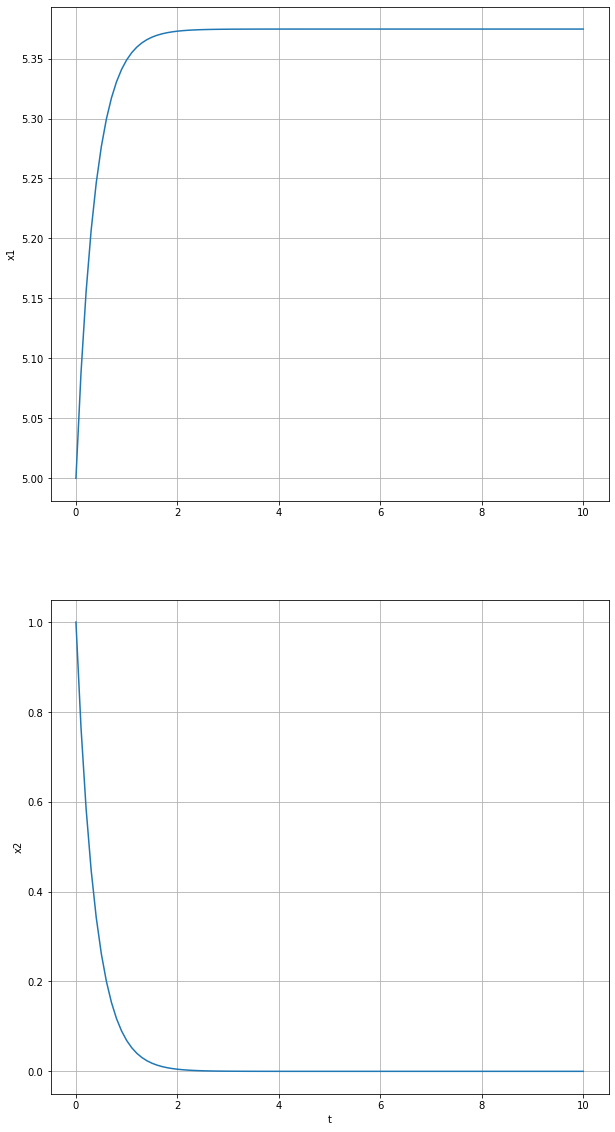

In [24]:
delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

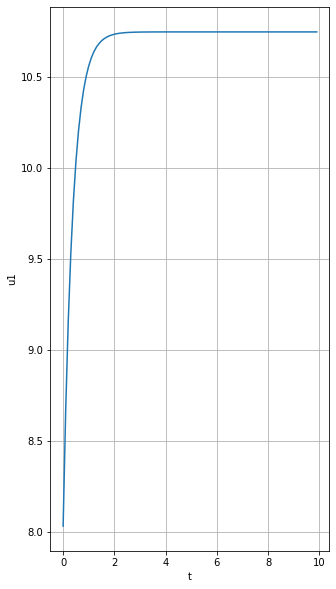

In [25]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(5, 10))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()